In [1]:
import random
import torch
import numpy as np
seed = 42 # Set the seed for reproducibility
torch.manual_seed(seed) # For PyTorch
torch.cuda.manual_seed_all(seed)  # If you're using GPU
np.random.seed(seed) # For NumPy (if you use NumPy anywhere)
random.seed(seed) # For Python's built-in random module (if you use it anywhere)


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import random
import time
import os
from tqdm import tqdm
from chronos import ChronosPipeline

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===============================
# Data Loading and Preprocessing
# ===============================

def load_datasets():
    """Load and preprocess train and test datasets"""
    train_set = pd.read_parquet('loaded_data/a_patient_data_processed_cluster.parquet')
    test_set = pd.read_parquet('loaded_data/c_patient_data_processed_cluster.parquet')
    return train_set, test_set

def pad_to_fixed_length(tensor, length=49):
    """Pad time series data to a fixed length"""
    current_length = tensor.size(0)
    if current_length < length:
        padding = torch.zeros((length - current_length, tensor.size(1)))
        return torch.cat([tensor, padding], dim=0)
    else:
        return tensor

def process_dataframe(df):
    """Process dataframe to prepare for embedding generation"""
    feature_columns = [col for col in df.columns if col not in ["RecordID", "In-hospital_death", "ICUType"]]
    list_of_patient_data = []
    patient_labels = []
    grouped = df.groupby("RecordID")
    
    for record_id, group in grouped:
        # Extract features and labels
        group_data = group[feature_columns].values
        group_tensor = torch.tensor(group_data, dtype=torch.float32)
        group_tensor_fixed = pad_to_fixed_length(group_tensor, length=49)
        
        # Keep the RecordID intact
        patient_data = pd.DataFrame(group_tensor_fixed.numpy(), columns=feature_columns)
        patient_data['RecordID'] = record_id  # Add the RecordID as a column
        
        list_of_patient_data.append(patient_data)
        # For the label, we assume that if any timestep indicates death, the patient is labeled as death (1)
        patient_labels.append(group["In-hospital_death"].max())
    
    # Combine all the patient data
    final_df = pd.concat(list_of_patient_data, ignore_index=True)
    final_labels = pd.DataFrame(patient_labels, columns=["In-hospital_death"])
    final_labels.index = [id for id in grouped.groups.keys()]  # Set RecordID as index
    
    return final_df, final_labels

# ===============================
# Embedding Generation Functions
# ===============================

def load_chronos_pipeline():
    """Load the Chronos pipeline for time series embedding"""
    pipeline = ChronosPipeline.from_pretrained(
        "amazon/chronos-t5-small",
        torch_dtype=torch.float16,
        device_map="auto" if torch.cuda.is_available() else None
    )
    return pipeline

def get_embedding_for_variable(variable_data, pipeline):
    """Generate an embedding for a single time series variable"""
    # Extract the relevant column and convert to tensor
    context = torch.tensor(variable_data.values, dtype=torch.float32)
    context = context.unsqueeze(0)  # Add batch dimension
    # Generate embeddings
    with torch.no_grad():
        embeddings, _ = pipeline.embed(context)
    
    return embeddings

def get_patient_embedding(patient_data, patient_id, pipeline, aggregation="mean"):
    """
    Generate embeddings for a patient by aggregating across all variables
    
    Args:
        patient_data: DataFrame containing patient data
        patient_id: RecordID for the patient
        pipeline: Chronos pipeline for embedding generation
        aggregation: Method to aggregate embeddings ("mean" or None)
                     If None, returns per-variable embeddings for smart aggregation
    """
    # Filter data for the specific patient
    patient_df = patient_data[patient_data['RecordID'] == patient_id]
    
    # Create a list to store embeddings for each variable
    embeddings = []
    
    # Iterate over each variable (excluding RecordID and Time)
    for column in patient_df.columns:
        if column != "RecordID" and column != "Time":
            # Get the embedding for the current variable
            variable_data = patient_df[column]
            embedding = get_embedding_for_variable(variable_data, pipeline)
            embeddings.append(embedding)
    
    # Return per-variable embeddings if requested
    if aggregation is None:
        return torch.cat(embeddings, dim=0)
    
    # Convert the list of embeddings into a tensor and compute the average
    embeddings_tensor = torch.cat(embeddings, dim=0)
    if aggregation == "mean":
        aggregated_embedding = torch.mean(embeddings_tensor, dim=0, keepdim=True)

    #print("size")
    #print(aggregated_embedding.size())
    return aggregated_embedding

def generate_all_embeddings(patient_data, labels, pipeline, file_path, aggregation="mean", batch_size=10):
    """
    Generate embeddings for all patients in the dataset
    
    Args:
        patient_data: DataFrame containing all patient data
        labels: DataFrame containing patient labels
        pipeline: Chronos pipeline for embedding generation
        file_path: Path to save embeddings
        aggregation: Method to aggregate embeddings across variables
        batch_size: Number of patients to process before saving
    """
    all_patient_embeddings = {}
    all_patient_ids = patient_data['RecordID'].unique()
    
    # Resume from previous progress if file exists
    if os.path.exists(file_path):
        print(f"Loading existing embeddings from {file_path}")
        existing_embeddings = torch.load(file_path, weights_only=False)
        all_patient_embeddings.update(existing_embeddings)
        
        # Filter out already processed patients
        processed_ids = set(all_patient_embeddings.keys())
        all_patient_ids = [id for id in all_patient_ids if id not in processed_ids]
        print(f"Resuming from {len(processed_ids)} already processed patients")
    
    # Process remaining patients
    total_patients = len(all_patient_ids)
    print(f"Processing embeddings for {total_patients} patients")
    
    start_time = time.time()
    for i, patient_id in enumerate(tqdm(all_patient_ids)):
        # Get the embedding for the current patient
        patient_embedding = get_patient_embedding(patient_data, patient_id, pipeline, aggregation)
        
        # Store the embedding
        all_patient_embeddings[patient_id] = patient_embedding
        
        # Save periodically
        if (i + 1) % batch_size == 0 or (i + 1) == total_patients:
            torch.save(all_patient_embeddings, file_path)
            
            # Print progress
            elapsed = time.time() - start_time
            remaining = (elapsed / (i + 1)) * (total_patients - i - 1)
            print(f"Processed {i+1}/{total_patients} patients. "
                  f"Elapsed: {elapsed/60:.1f} min. "
                  f"Remaining: {remaining/60:.1f} min.")
    
    print(f"All embeddings saved to {file_path}")
    return all_patient_embeddings


Using device: cuda


In [3]:

# ===============================
# Linear Probe Implementation
# ===============================

class LinearProbe(nn.Module):
    def __init__(self, input_dim):
        """Simple linear probe for classification"""
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        return self.sigmoid(self.linear(x))

def prepare_embedding_dataset(embeddings_dict, labels_df):
    """Prepare embeddings and labels for model training"""
    record_ids = list(embeddings_dict.keys())
    
    # Filter to only include record IDs that have labels
    valid_record_ids = [rid for rid in record_ids if rid in labels_df.index]
    
    # Stack embeddings and get corresponding labels
    embeddings_list = [embeddings_dict[rid].squeeze(0) for rid in valid_record_ids]
    labels_list = [labels_df.loc[rid, "In-hospital_death"] for rid in valid_record_ids]
    
    X = torch.stack(embeddings_list)
    y = torch.tensor(labels_list, dtype=torch.float32).unsqueeze(1)
    
    return X, y, valid_record_ids

def train_linear_probe(train_embeddings, train_labels, val_embeddings=None, val_labels=None, 
                      num_epochs=100, lr=0.001, batch_size=32, early_stopping=10):
    """Train a linear probe on embeddings"""
    # Prepare datasets
    #X_train, y_train, _ = prepare_embedding_dataset(train_embeddings, train_labels)
    X_train = torch.stack(list(train_embeddings.values()))  # Stack all patient embeddings into a tensor

    # Ensure the input data (X_train) is of type float32
    X_train = X_train.float()
    X_train_flat = X_train.view(X_train.size(0), -1)
    X_train_flat= X_train_flat.to(device)
    y_train = train_labels.to(device)
    X_test_flat = X_train_flat.to(device)  # Use the same data for testing (adjust as per your actual data)
    y_test = train_labels.to(device)  # Same target labels for testing
    X_test_flat = X_test_flat.to(device)
    y_test = y_test.to(device)

   # print(X_train_flat)
    #print("X_train_flat.size()")
   # print(X_train_flat.size())

    # Create model
    #input_dim = X_train.shape[1]
    input_dim = 50*512
   #print("input_dim")
    #print(input_dim)
    model = LinearProbe(input_dim).to(device)
    
    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Create data loader
    train_dataset = TensorDataset(X_train_flat, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Validation data
    has_validation = val_embeddings is not None and val_labels is not None
    if has_validation:
        X_val, y_val, _ = prepare_embedding_dataset(val_embeddings, val_labels)
        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            #inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = inputs.to(device).float(), targets.to(device).float()
            targets = targets.unsqueeze(1)
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        if has_validation:
            model.eval()
            val_loss = 0.0
            all_preds = []
            all_targets = []
            
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    targets = targets.unsqueeze(1)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                    all_preds.append(outputs.cpu())
                    all_targets.append(targets.cpu())
            
            val_loss /= len(val_loader)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save best model
                torch.save(model.state_dict(), 'best_linear_probe.pth')
            else:
                patience_counter += 1
                if patience_counter >= early_stopping:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
            
            # Calculate validation metrics
            all_preds = torch.cat(all_preds).numpy()
            all_targets = torch.cat(all_targets).numpy()
            val_auc = roc_auc_score(all_targets, all_preds)
            
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Val Loss: {val_loss:.4f}, '
                  f'Val AUC: {val_auc:.4f}')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')
    
    # Load best model if validation was used
    if has_validation:
        model.load_state_dict(torch.load('best_linear_probe.pth'))
    
    return model

def evaluate_model(model, embeddings_dict, labels_df):
    """Evaluate model on test data"""
    # Prepare test data
    #X_test, y_test, record_ids = prepare_embedding_dataset(embeddings_dict, labels_df)
    #X_test, y_test = X_test.to(device), y_test.to(device)

    X_test = torch.stack(list(embeddings_dict.values()))  # Stack all patient embeddings into a tensor
    X_test = X_test.float() # Ensure the input data (X_train) is of type float32
    X_test_flat = X_test.view(X_test.size(0), -1)
    X_test_flat= X_test_flat.to(device)
   
    y_test = labels_df.to(device)  # Same target labels for testing
    model = model.to(device)
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_flat)
        probs = predictions.cpu().numpy()
        preds = (probs > 0.5).astype(int)
        y_true = y_test.cpu().numpy()
    
    # Calculate metrics
    auc = roc_auc_score(y_true, probs)
    accuracy = accuracy_score(y_true, preds)
    precision = precision_score(y_true, preds)
    recall = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    
    # Print metrics
    print(f"Test Results:")
    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {
        "auc": auc,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "predictions": probs,
        "true_labels": y_true
    }

# ===============================
# Smart Aggregation Model
# ===============================

class ChannelAttention(nn.Module):
    def __init__(self, embedding_dim):
        """
        Channel attention network that learns weights for different variables
        
        Args:
            embedding_dim: Dimension of each variable's embedding
        """
        super(ChannelAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, embeddings_per_variable):
        """
        Args:
            embeddings_per_variable: Tensor of shape [num_variables, embedding_dim]
        """
        # Calculate attention score for each variable
        attention_scores = self.attention(embeddings_per_variable)
        attention_weights = self.softmax(attention_scores)
        
        # Apply attention weights
        weighted_embeddings = embeddings_per_variable * attention_weights
        
        # Sum across variables
        aggregated_embedding = torch.sum(weighted_embeddings, dim=0)
        
        return aggregated_embedding, attention_weights

class SmartAggregationModel(nn.Module):
    def __init__(self, embedding_dim, num_variables=41):
        """
        Model that learns to intelligently aggregate variable embeddings
        
        Args:
            embedding_dim: Dimension of each variable's embedding
            num_variables: Number of time series variables
        """
        super(SmartAggregationModel, self).__init__()
        self.channel_attention = ChannelAttention(embedding_dim)
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        """
        Args:
            x: Tensor of shape [batch_size, num_variables, embedding_dim]
        """
        batch_size = x.size(0)
        outputs = []
        attention_weights_list = []
        
        # Process each sample in the batch
        for i in range(batch_size):
            # Get variable embeddings for this sample
            embeddings_per_variable = x[i]
            
            # Apply channel attention
            aggregated, attention_weights = self.channel_attention(embeddings_per_variable)
            
            # Classify
            output = self.classifier(aggregated)
            
            outputs.append(output)
            attention_weights_list.append(attention_weights)
        
        # Combine results
        outputs = torch.cat(outputs, dim=0)
        attention_weights = torch.stack(attention_weights_list)
        
        return outputs, attention_weights

def generate_variable_embeddings(patient_data, record_ids, pipeline):
    """Generate per-variable embeddings for smart aggregation"""
    all_patient_embeddings = {}
    
    for patient_id in tqdm(record_ids):
        # Filter data for this patient
        patient_df = patient_data[patient_data['RecordID'] == patient_id]
        
        variable_embeddings = []
        for column in patient_df.columns:
            if column != "RecordID" and column != "Time":
                # Get the embedding for the current variable
                variable_data = patient_df[column]
                context = torch.tensor(variable_data.values, dtype=torch.float32).unsqueeze(0)
                #print(len(context))
                with torch.no_grad():
                    embedding, _ = pipeline.embed(context)
                variable_embeddings.append(embedding.squeeze(0))
        
        # Stack embeddings for all variables [num_variables, embedding_dim]
        all_patient_embeddings[patient_id] = torch.stack(variable_embeddings)
    
    return all_patient_embeddings

def prepare_variable_embeddings_dataset(embeddings_dict, labels):
    record_ids = list(embeddings_dict.keys())
    
    # Check if labels is a DataFrame or a tensor
    if hasattr(labels, 'index'):
        # If it's a DataFrame, filter based on index
        valid_record_ids = [rid for rid in record_ids if rid in labels.index]
        embeddings_list = [embeddings_dict[rid] for rid in valid_record_ids]
        labels_tensor = torch.tensor(labels.loc[valid_record_ids].values)
    else:
        # Assume labels is a tensor and order matches record_ids
        embeddings_list = [embeddings_dict[rid] for rid in record_ids]
        labels_tensor = labels
        valid_record_ids = record_ids
    
    return torch.stack(embeddings_list), labels_tensor, valid_record_ids

def train_smart_aggregation_model(train_embeddings, train_labels, val_embeddings=None, val_labels=None,
                                 num_epochs=100, lr=0.001, batch_size=32, early_stopping=10):
    """Train the smart aggregation model"""
    # Prepare datasets
    #X_train, y_train, _ = prepare_variable_embeddings_dataset(train_embeddings, train_labels)

    X_train = torch.stack(list(train_embeddings.values()))  # Stack all patient embeddings into a tensor
    print("here")
    print(X_train.size())
    print(len(X_train))
    # Ensure the input data (X_train) is of type float32
    X_train = X_train.float()
    X_train_flat = X_train.mean(dim=2)
    print("here2")
    print(X_train_flat.size())
    X_train_flat= X_train_flat.to(device)
    y_train = train_labels.float().to(device)
    
    # Get dimensions
    num_variables = X_train.shape[1] # second shape dimension  [500, 40, 50, 512]
    embedding_dim = 512
    
    # Create model
    model = SmartAggregationModel(embedding_dim, num_variables).to(device)
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Create data loader
    train_dataset = TensorDataset(X_train_flat, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Validation data
    has_validation = val_embeddings is not None and val_labels is not None
    if has_validation:
        X_val, y_val, _ = prepare_variable_embeddings_dataset(val_embeddings, val_labels)
        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs, _ = model(inputs)
            #print(targets)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        if has_validation:
            model.eval()
            val_loss = 0.0
            all_preds = []
            all_targets = []
            
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs, _ = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                    all_preds.append(outputs.cpu())
                    all_targets.append(targets.cpu())
            
            val_loss /= len(val_loader)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save best model
                torch.save(model.state_dict(), 'best_smart_aggregation.pth')
            else:
                patience_counter += 1
                if patience_counter >= early_stopping:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
            
            # Calculate validation metrics
            all_preds = torch.cat(all_preds).numpy()
            all_targets = torch.cat(all_targets).numpy()
            val_auc = roc_auc_score(all_targets, all_preds)
            
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Val Loss: {val_loss:.4f}, '
                  f'Val AUC: {val_auc:.4f}')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')
    
    # Load best model if validation was used
    if has_validation:
        model.load_state_dict(torch.load('best_smart_aggregation.pth'))
    
    return model

def evaluate_smart_aggregation_model(model, embeddings_dict, labels_df):
    """Evaluate the smart aggregation model"""
    # Prepare test data
    X_test, y_test, record_ids = prepare_variable_embeddings_dataset(embeddings_dict, labels_df)
    X_test, y_test = X_test.to(device), y_test.to(device)

    X_test = torch.stack(list(embeddings_dict.values()))  # Stack all patient embeddings into a tensor
    print("here")
    print(X_test.size())
    print(len(X_test))
    # Ensure the input data (X_train) is of type float32
    X_test = X_test.float()
    X_test_flat = X_test.mean(dim=2)
    print("here2")
    print(X_test_flat.size())
    X_test_flat= X_test_flat.to(device)
    y_test = labels_df.float().to(device)
    
    # Get dimensions
    num_variables = X_test.shape[1] # second shape dimension  [500, 40, 50, 512]
    embedding_dim = 512
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        #predictions, attention_weights = model(X_test)
        predictions, attention_weights = model(X_test_flat)
        probs = predictions.cpu().numpy()
        preds = (probs > 0.5).astype(int)
        y_true = y_test.cpu().numpy()
    
    # Calculate metrics
    auc = roc_auc_score(y_true, probs)
    accuracy = accuracy_score(y_true, preds)
    precision = precision_score(y_true, preds)
    recall = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    
    # Print metrics
    print(f"Test Results:")
    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Analyze attention weights
    mean_attention = attention_weights.mean(dim=0).cpu().squeeze()
    
    return {
        "auc": auc,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "predictions": probs,
        "true_labels": y_true,
        "attention_weights": mean_attention.numpy()
    }

def visualize_attention_weights(attention_weights, feature_names):
    """Visualize the learned attention weights across variables"""
    # Convert attention_weights to a tensor if it's not already one
    if not isinstance(attention_weights, torch.Tensor):
        attention_weights = torch.tensor(attention_weights)
    
    # Sort by weight values
    sorted_idx = torch.argsort(attention_weights, descending=True)
    sorted_weights = attention_weights[sorted_idx]
    sorted_features = [feature_names[i] for i in sorted_idx.tolist()]
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(sorted_features)), sorted_weights.numpy(), align='center')
    plt.yticks(range(len(sorted_features)), sorted_features)
    plt.xlabel('Attention Weight')
    plt.title('Variable Importance (Attention Weights)')
    plt.tight_layout()
    plt.savefig('variable_attention_weights.png')
    plt.show()



Starting ICU Patient Analysis Pipeline with Chronos Embeddings
Loading and preprocessing data...
Loading Chronos pipeline...

=== Task 1: Generate Patient Embeddings ===
Loading pre-computed embeddings train...
Loading pre-computed embeddings test...
Index(['ALP', 'ALT', 'AST', 'Age', 'Albumin', 'BUN', 'Bilirubin',
       'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Gender',
       'Glucose', 'HCO3', 'HCT', 'HR', 'Height', 'ICUType',
       'In-hospital_death', 'K', 'Lactate', 'MAP', 'MechVent', 'Mg',
       'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'PaCO2', 'PaO2', 'Platelets',
       'RecordID', 'RespRate', 'SaO2', 'SysABP', 'Temp', 'Time', 'TroponinI',
       'TroponinT', 'Urine', 'WBC', 'Weight', 'pH'],
      dtype='object')
RecordID
132539.0    47
132540.0    48
132541.0    47
132543.0    48
132545.0    46
            ..
142665.0    48
142667.0    26
142670.0    44
142671.0    45
142673.0    47
Name: Time, Length: 3997, dtype: int64
len(y_train)
3997
Index(['ALP', 'ALT', 

/cluster/courses/ml4h/project1env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Visualizing variable importance...


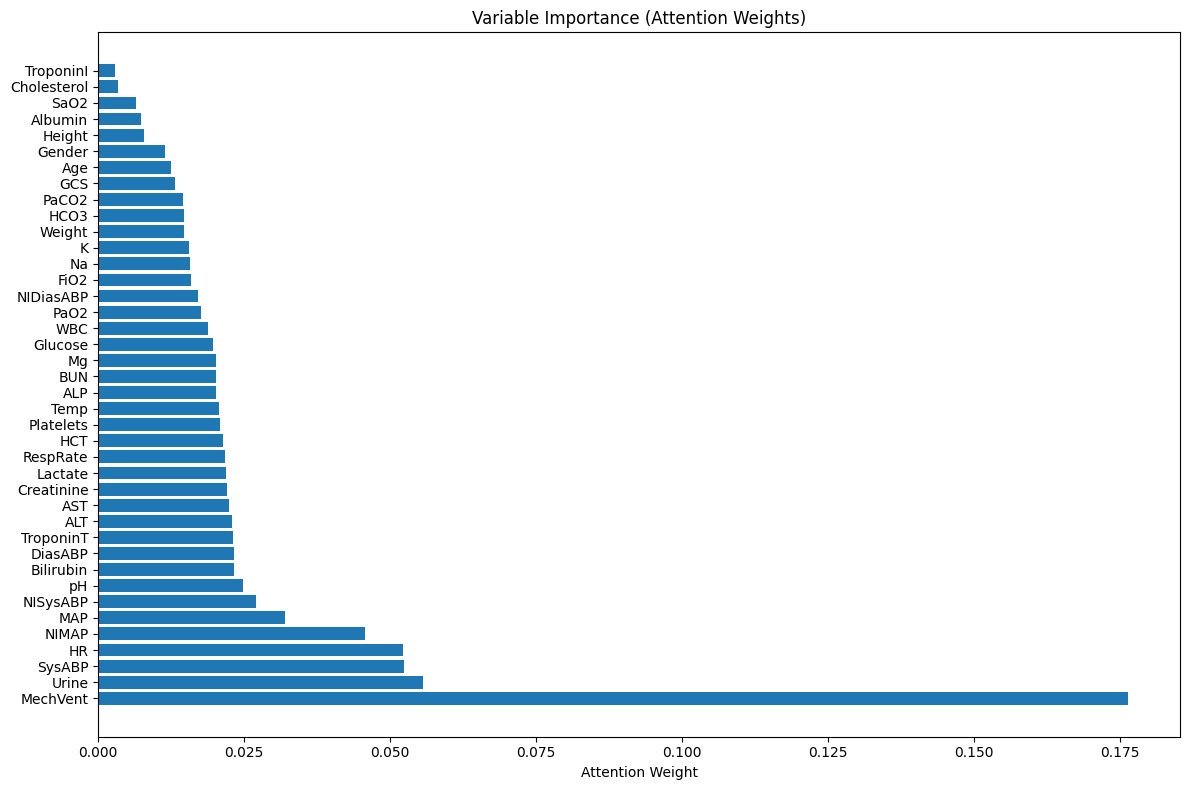


=== Performance Comparison ===


NameError: name 'linear_results' is not defined

In [4]:

# ===============================
# Main Execution
# ===============================

def main():
    print("Starting ICU Patient Analysis Pipeline with Chronos Embeddings")
    
    # Step 1: Load and preprocess data
    print("Loading and preprocessing data...")
    train_df, test_df = load_datasets()
    processed_train, train_labels = process_dataframe(train_df)
    processed_test, test_labels = process_dataframe(test_df)
    
    # Step 2: Load Chronos pipeline
    print("Loading Chronos pipeline...")
    pipeline = load_chronos_pipeline()
    
    # Extract feature names (excluding RecordID and Time)
    feature_names = [col for col in processed_train.columns 
                     if col != "RecordID" and col != "Time"]
    
    # Step 3: Generate embeddings
    print("\n=== Task 1: Generate Patient Embeddings ===")
    
    # Check if embeddings already exist
    train_emb_file = 'train_embeddings_linear.pth'
    test_emb_file = 'test_embeddings_linear.pth'
    
    if os.path.exists(train_emb_file):
        print("Loading pre-computed embeddings train...")
        train_embeddings = torch.load(train_emb_file, weights_only=False)
    else:
        print("Generating embeddings for training data...")
        train_embeddings = generate_all_embeddings(
            processed_train, train_labels, pipeline, train_emb_file)

    if os.path.exists(test_emb_file):
        print("Loading pre-computed embeddings test...")
        test_embeddings = torch.load(test_emb_file, weights_only=False)
    else:
        print("Generating embeddings for testing data...")
        test_embeddings = generate_all_embeddings(
            processed_test, test_labels, pipeline, test_emb_file)

    #print(train_embeddings)
    
    df_training = pd.read_parquet("loaded_data/a_patient_data_processed_cluster.parquet", engine='pyarrow')
    df_training.head()
    print(df_training.columns)
    timestamp_count = df_training.groupby('RecordID')['Time'].nunique()
    print(timestamp_count)
    # check if ICUType is a column
    columns_to_check = ['ICUType', 'In-hospital_death']
    missing_columns = [col for col in columns_to_check if col not in df_training.columns]
    missing_columns
    df_testing_with_label = df_training
    #y_train = df_testing_with_label['In-hospital_death'].values.unique()  # Binary target (0 or 1)
    y_train = df_testing_with_label.groupby('RecordID')['In-hospital_death'].last().values
    y_train = torch.tensor(y_train, dtype=torch.long)  # Convert labels to tensor
    print("len(y_train)")
    print(len(y_train))

    df_testing = pd.read_parquet("loaded_data/c_patient_data_processed_cluster.parquet", engine='pyarrow')
    df_testing.head()
    print(df_testing.columns)
    timestamp_count = df_testing.groupby('RecordID')['Time'].nunique()
    print(timestamp_count)
    df_testing_with_label = df_testing
    #y_train = df_testing_with_label['In-hospital_death'].values.unique()  # Binary target (0 or 1)
    y_test = df_testing_with_label.groupby('RecordID')['In-hospital_death'].last().values
    y_test = torch.tensor(y_test, dtype=torch.long)  # Convert labels to tensor
    print("len(y_test)")
    print(len(y_test))
    
    # Step 4: Train and evaluate linear probe
    print("\n=== Task 2: Train Linear Probe ===")
    linear_model = train_linear_probe(
        train_embeddings, y_train, 
        num_epochs=50, lr=0.001, batch_size=32)
    
    #linear_results = evaluate_model(linear_model, test_embeddings, y_test)
    
    # Step 5: Smart aggregation approach
    print("\n=== Task 3: Smart Variable Aggregation ===")
    
    # Generate per-variable embeddings for a subset of patients to demonstrate
    print("Generating per-variable embeddings...")
    var_train_emb_file = 'train_variable_embeddings.pth'
    var_test_emb_file = 'test_variable_embeddings.pth'
    
    train_subset = processed_train['RecordID'].unique()
    test_subset = processed_test['RecordID'].unique()
    
    if os.path.exists(var_train_emb_file):
        print("Loading pre-computed embeddings train...")
        train_var_embeddings = torch.load(var_train_emb_file, weights_only=False)
    else:
        print(f"Generating variable embeddings for {len(train_subset)} training patients...")
        train_var_embeddings = generate_variable_embeddings(
            processed_train, train_subset, pipeline)
        torch.save(train_var_embeddings, var_train_emb_file)

    print(processed_train.columns)
    print(len(processed_train.columns))
    
    if os.path.exists(var_test_emb_file):
        print("Loading pre-computed embeddings test...")
        test_var_embeddings = torch.load(var_test_emb_file, weights_only=False)
    else:
        print(f"Generating variable embeddings for {len(test_subset)} test patients...")
        test_var_embeddings = generate_variable_embeddings(processed_test, test_subset, pipeline)
        torch.save(test_var_embeddings, var_test_emb_file)
    
    #print(train_var_embeddings.size())
    # Train smart aggregation model
    print("Training smart aggregation model...")
    smart_model = train_smart_aggregation_model(
        train_var_embeddings, y_train,
        num_epochs=50, lr=0.001, batch_size=16)
    
    # Evaluate smart aggregation model
    smart_results = evaluate_smart_aggregation_model(
        smart_model, test_var_embeddings, y_test)
    
    # Visualize variable attention weights
    print("Visualizing variable importance...")
    visualize_attention_weights(smart_results["attention_weights"], feature_names)
    
    # Compare results
    print("\n=== Performance Comparison ===")
    print(f"Linear Probe AUC: {linear_results['auc']:.4f}")
    print(f"Smart Aggregation AUC: {smart_results['auc']:.4f}")
    
    print("Pipeline completed successfully!")

if __name__ == "__main__":
    main()